In [1]:
###SASSIE UNDER ICE FLOAT DATA USE AND VISUALIZATION##
import numpy as np
import xarray as xr
import glob 
from datetime import datetime, timedelta 
import matplotlib.pyplot as plt
import cartopy
import matplotlib
import os
import sys
import pandas as pd
import requests


##LOCAL DIRECTORY TO UIF DATA
dir_in = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/L2/UIF/'

##LOCAL DIRECTORY FOR AMSR SEA ICE DATA TO BE STORED
ice_dir = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/sea_ice/'
if not os.path.exists(ice_dir):
    os.makedirs(ice_dir)

##LOCAL DIRECTORY TO SHIP TRACK DATA
ship_dir = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/L2/TSG/SASSIE_Fall_2022_Shipboard_TSG.nc'
    
##LOCAL DIRECTORY TO SAVE FIGURES
fig_dir = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/UIF/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

##READ IN BATHYMETRY DATA
url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo2.nc'
etopodata = xr.open_dataset(url)

In [2]:
##LOAD IN THE NETCDF FILES AND LOOK AT THEIR METADATA  
file = (dir_in + 'SASSIE_Fall_2022_under_ice_float.nc')
    
#SHOWS THE GLOBAL METEADATA AND WHICH VARIABLES ARE IN THE FILE
ds = xr.open_dataset(file)
#print(ds)

#SHOW THE VARIABLE ATTRIBUTES FOR ANY GIVEN VARIABLE WITHIN THE FILE. Replace "salinity" with your variable of interest:
variable_info = ds.salinity
#print(variable_info)

In [3]:
def define_variable_attributes(var):
    if (var =='salinity')|(var=='salinity_HRCTD'):
        colormap = 'viridis'
        var_label = 'Salinity'
    if (var =='temperature')|(var=='temperature_HRCTD'):
        colormap = 'plasma'
        var_label = 'Water Temperature ($^{\circ}$C)'
    return colormap,var_label

In [5]:
##USE THIS TO PLOT THE FLOAT SURFACEING LOCATIONS ON THE WHOLE CAMPAIGN MAP 
def map_UIF_GPS(ship_track=True,bathymetry_data=True,ice_data=False):
    
    ##CREATE A MAP WITH LAND AND CITY MARKERS AND SHIP TRACK. To show the whole campaign area, use latmin = 70, latmax =74,lonmin=-157,lonmax=-140.  
    latmin = 72
    latmax =74
    lonmin=-156
    lonmax=-149
    
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=-150))
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=cartopy.crs.PlateCarree())
    ax.coastlines(color='k')  
    ax.add_feature(cartopy.feature.LAND, facecolor = '0.50')
    ax.add_feature(cartopy.feature.RIVERS,facecolor='blue')

    
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3)
    ax.set_title('Under Ice Float GPS Readings',fontsize=20,pad=1.5) 
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(60,82,1))
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-180,180,2))
    gl.top_labels = False
    gl.bottom_labels = True
    gl.right_labels = False
    
    if (latmin<71.2906) & (lonmin<-156.7886):
        utqiagvik = ax.scatter(-156.7886,71.2906,s=100,transform=cartopy.crs.PlateCarree(),c='red',marker = '*',label='Utqiagvik, AK',zorder=2)
    if (latmin<70.2002) & (lonmax>-148.4597):
        deadhorse = ax.scatter(-148.4597,70.2002,s=100,c='cyan',transform=cartopy.crs.PlateCarree(),marker = '*',label='Deadhorse, AK',zorder=2)
    
    ##OPTIONAL MAP ADD-ONs
    if ship_track==True:
        #ADD SHIP TRACK DATA
        ds_ship = xr.open_dataset(ship_dir)
        ship_time = np.squeeze(ds_ship['time'])
        ship_lat = np.squeeze(ds_ship['latitude'])
        ship_lon = np.squeeze(ds_ship['longitude'])
        track = ax.plot(ship_lon, 
                     ship_lat,linewidth = 0.5,
                     c='black',
                       transform=cartopy.crs.PlateCarree(),label = 'Ship Track',zorder=1)
        plt.legend(loc=2)
        
    if bathymetry_data == True:    
        ##ADD BATHYMETRY DATA
        topoin = etopodata.rose.values[0:-1:5,1:-1:5]
        lons = etopodata.etopo2_x.values[0:-1:5]
        lats = etopodata.etopo2_y.values[0:-1:5]
        lons_in_range = lons[np.where((lons >lonmin-1) & (lons<lonmax+1))]
        lats_in_range = lats[np.where((lats >latmin-1) & (lats<latmax+1))]
        topo_in_range = np.squeeze(topoin[np.squeeze(np.where((lats >latmin-1) & (lats<latmax+1))),:][:,np.where((lons >lonmin-1) & (lons<lonmax+1))])
        [bathy_lon,bathy_lat] = np.meshgrid(lons_in_range,lats_in_range)

        bathy = ax.contour(bathy_lon,bathy_lat,topo_in_range,np.arange(-6000,-1000,300),transform=cartopy.crs.PlateCarree(),cmap='gray',alpha = 0.2,zorder = 0)
        
    if ice_data==True:
        ##ADD ICE DATA
        #get ice data at start of time range
        start_time = pd.to_datetime(min(xr.open_dataset(file).time_GPS.values),'ns')
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+'.he5' 
        i=0
        time_tmp=start_time - timedelta(days=i)
        while os.path.isfile(ice_dir+filename_si)==False and i<15:
            time_tmp=start_time - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(ice_dir+filename_si, 'wb') as f:
                f.write(url.content)
            i=i+1

        #get ice data at end of time range 
        end_time = pd.to_datetime(max(xr.open_dataset(file).time_GPS.values),'ns')
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+'.he5' 
        i=0
        time_tmp=end_time - timedelta(days=i)
        while os.path.isfile(ice_dir+filename_si)==False and i<15:
            time_tmp=end_time - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(ice_dir+filename_si, 'wb') as f:
                f.write(url.content)       
            i=i+1

        #apply ice data at the end of the time range (ice sheet growth) in red
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+'.he5' 
        if os.path.isfile(ice_dir+filename_si):
            dsc = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))

            var1[indx] = 0
            ice_growth_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_growth_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Reds_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())

        #apply ice data at the start of the time range in blue
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+'.he5' 
        if os.path.isfile(ice_dir+filename_si):
            dsc = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(ice_dir+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))
            var1[indx] = 0
            ice_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Blues_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())
        
    
    ##APPLY THE TIME AND LOCATION DATA FROM THE GPS 
    ds_UIF = xr.open_dataset(file)
    GPS_time = np.squeeze(ds_UIF['time_GPS'])
    GPS_lat = np.squeeze(ds_UIF['latitude_GPS'])
    GPS_lon = np.squeeze(ds_UIF['longitude_GPS'])
    
    #Set time limits of the float data
    start_time = min(GPS_time)
    end_time = max(GPS_time)

    var_min = start_time.astype('int64')
    var_max =end_time.astype('int64')

    deployment_track = ax.scatter(GPS_lon,GPS_lat,s = 5,
                   c = GPS_time,cmap = 'jet',
                   transform=cartopy.crs.PlateCarree(),zorder=2,vmin=var_min,vmax=var_max)

    cbar = fig.colorbar(deployment_track, ax=ax, orientation="horizontal", pad=0.1)
    cbar.set_label(label='Date',size='large',weight='bold')
    cbar_tick_array=(np.linspace(start_time.astype('int64'),end_time.astype('int64'),5))
    cbar.set_ticks(cbar_tick_array)
    cbar.set_ticklabels(pd.to_datetime(cbar_tick_array).date)  

    #SAVE FIGURE
    if not os.path.exists(fig_dir+'maps/'):
        os.makedirs(fig_dir+'maps/')
    print('Saving Output Image:  '+fig_dir+'maps/UIF_GPS_readings.png')
    plt.savefig(fig_dir+'maps/UIF_GPS_readings_.png',dpi='figure',format='png')
    

Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/UIF/maps/UIF_GPS_readings.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


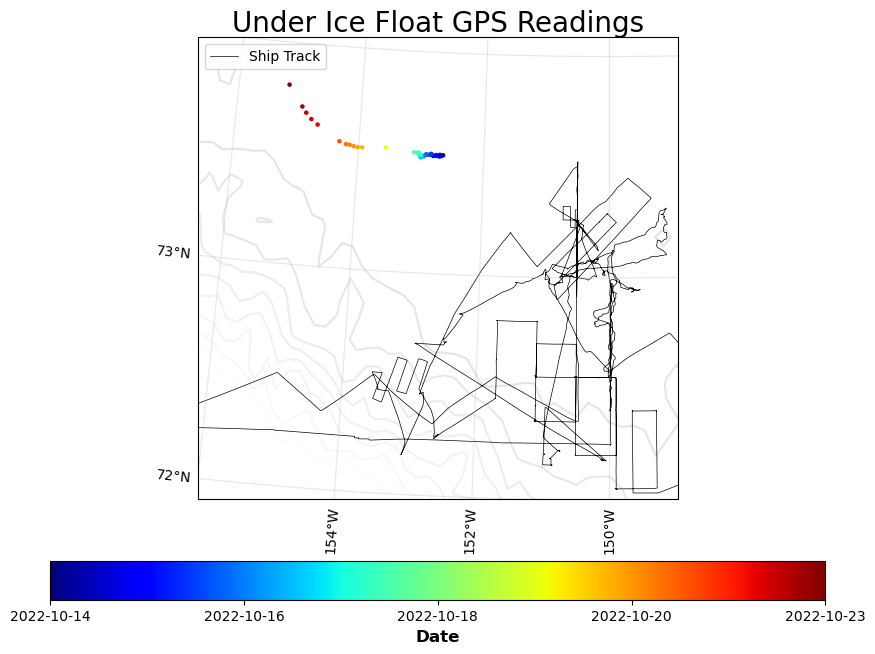

In [6]:
map_UIF_GPS()

In [ ]:
##MAKES A 3D PLOT OF THE CTD VARIABLES WITH INTERPOLATED LAT/LON FOR A TIME RANGE WITHIN THE GPS MEASUREMENTS
def plot_CTD(start_time,end_time,CTD_unit,var):
   
    ##PULL OUT THE DATA WITHIN THE START AND END TIME RANGE
    ds_limited = ds.sel(time_GPS=slice(start_time,end_time),time_CTD=slice(start_time,end_time))
    
    ## MAKE AN INTERPOLATED CTD LAT AND LON ARRAY FOR PLOTTING PURPOSES ONLY. PULL OUT THE VARIABLE OF INTEREST AND PRESSURE AT THESE TIMES TOO. 
    lat_array = []
    lon_array = []
    pres_array = []
    var_array = []
    for i in range(len(ds_limited.time_GPS)-1):
        #STEP 1 Find start and end coordinates 
        start_time_GPS = ds_limited['time_GPS'].values[i]
        end_time_GPS = ds_limited['time_GPS'].values[i+1]
        start_lat = ds_limited['latitude_GPS'].values[i]
        end_lat = ds_limited['latitude_GPS.values'][i+1]
        start_lon = ds_limited['longitude_GPS'].values[i]
        end_lon = ds_limited['longitude_GPS'].values[i+1]
        # STEP 2 Find the number of measurements taken between start_time and end_time 
        measurements = ds_limited.sel(time_CTD=slice(start_time_GPS,end_time_GPS))
        number_of_measurements = len(measurements.time_CTD.values)
        #STEP 3 create an evenly spaced array of lat and lons connecting them. 
        lat_array = np.append(lat_array,np.linspace(start_lat,end_lat,number_of_measurements))
        lon_array = np.append(lon_array,np.linspace(start_lon,end_lon,number_of_measurements))
        #STEP 4 create a pressure and a var array that correspond to these measurements.
        pressure = measurements['pressure'].values[CTD_unit-1,:]
        pres_array = np.append(pres_array,pressure)
        var_current = measurements[var].values[CTD_unit-1,:]
        var_array = np.append(var_array,var_current)
    
    ##SET UP THE 3D PLOT 
    colormap,var_label = define_variable_attributes(var)

    #To show the whole campaign area, use latmin = 70, latmax =74,lonmin=-157,lonmax=-140
    latmin = min(lat_array)
    latmax = max(lat_array)
    lonmin = min(lon_array)
    lonmax = max(lon_array)
    pmin = min(pres_array)
    pmax = max(pres_array)+0.5
    
      
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection='3d',computed_zorder=False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False    
    
    ax.set_title('Under Ice Float'+' '+var_label+' '+'Readings from CTD Sensor '+str(CTD_unit)+'\n from '+str(start_time.year)+'/'+str(start_time.month).zfill(2)+'/'+str(start_time.day).zfill(2)+' to '+str(end_time.year)+'/'+str(end_time.month).zfill(2)+'/'+str(end_time.day).zfill(2),fontsize=15,pad=None)

    ax.set_xlim(lonmin, lonmax); ax.set_ylim(latmin,latmax); ax.set_zlim(pmin,pmax);
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    xticks = list(np.linspace(lonmin,lonmax,4))
    ax.set_xticks(np.around(xticks,2))
    yticks = list(np.linspace(latmin,latmax,4))
    ax.set_yticks(np.around(yticks,2))
    zticks = list(np.linspace(pmin,pmax,4))
    ax.set_zticks(np.around(zticks,2))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Pressure (dbar)')
    ax.view_init(210,60)
    
    ##APPLY THE FLOAT DATA
    a = ax.scatter(lon_array,lat_array,pres_array,c=(var_array),cmap = colormap,s=2,zorder=1)    
    fig.colorbar(a,label = var_label)
    
    
    ##SAVE THE FIGURE:
    if not os.path.exists(fig_dir+var+'/'):
        os.makedirs(fig_dir+var+'/')
    
    print('Saving Output Image:  '+fig_dir+var+'/'+'UIF_CTD'+str(CTD_unit)+'_'+var+'_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+str(start_time.hour).zfill(2)+str(start_time.minute).zfill(2)+'_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+str(end_time.hour).zfill(2)+str(end_time.minute).zfill(2)+'.png')
    plt.savefig(fig_dir+var+'/'+'UIF_CTD'+str(CTD_unit)+'_'+var+'_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+str(start_time.hour).zfill(2)+str(start_time.minute).zfill(2)+'_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+str(end_time.hour).zfill(2)+str(end_time.minute).zfill(2)+'.png',dpi='figure',format='png')
    



In [ ]:
plot_CTD(datetime(2022,10,14),datetime(2022,10,23),1,'temperature')
plot_CTD(datetime(2022,10,14),datetime(2022,10,23),1,'salinity')
plot_CTD(datetime(2022,10,14),datetime(2022,10,23),2,'temperature')
plot_CTD(datetime(2022,10,14),datetime(2022,10,23),2,'salinity')

In [ ]:
##MAKES A 3D PLOT OF THE HRCTD VARIABLES WITH INTERPOLATED LAT/LON FOR A TIME RANGE WITHIN THE GPS MEASUREMENTS
def plot_HRCTD(start_time,end_time,var,var_min,var_max):
   
    ##PULL OUT THE DATA WITHIN THE START AND END TIME RANGE
    ds_limited = ds.sel(time_GPS=slice(start_time,end_time),time_HRCTD=slice(start_time,end_time))
    
    ## MAKE AN INTERPOLATED CTD LAT AND LON ARRAY FOR PLOTTING PURPOSES ONLY. PULL OUT THE VARIABLE OF INTEREST AND PRESSURE AT THESE TIMES TOO. 
    lat_array = []
    lon_array = []
    pres_array = []
    var_array = []
    for i in range(len(ds_limited.time_GPS)-1):
        #STEP 1 Find start and end coordinates 
        start_time_GPS = ds_limited['time_GPS'].values[i]
        end_time_GPS = ds_limited['time_GPS'].values[i+1]
        start_lat = ds_limited['latitude_GPS'].values[i]
        end_lat = ds_limited['latitude_GPS.values'][i+1]
        start_lon = ds_limited['longitude_GPS'].values[i]
        end_lon = ds_limited['longitude_GPS'].values[i+1]
        # STEP 2 Find the number of measurements taken between start_time and end_time 
        measurements = ds_limited.sel(time_HRCTD=slice(start_time_GPS,end_time_GPS))
        number_of_measurements = len(measurements.time_HRCTD.values)
        #STEP 3 create an evenly spaced array of lat and lons connecting them. 
        lat_array = np.append(lat_array,np.linspace(start_lat,end_lat,number_of_measurements))
        lon_array = np.append(lon_array,np.linspace(start_lon,end_lon,number_of_measurements))
        #STEP 4 create a pressure and a var array that correspond to these measurements.
        pressure = measurements['pressure_HRCTD'].values
        pres_array = np.append(pres_array,pressure)
        var_current = measurements[var+'_HRCTD'].values
        var_array = np.append(var_array,var_current)
    
    
    ##SET UP THE 3D PLOT 
    colormap,var_label = define_variable_attributes(var)

    #To show the whole campaign area, use latmin = 70, latmax =74,lonmin=-157,lonmax=-140
    latmin = min(lat_array)
    latmax = max(lat_array)
    lonmin = min(lon_array)
    lonmax = max(lon_array)
    pmin = min(pres_array)
    pmax = max(pres_array)+0.5

    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection='3d',computed_zorder=False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False    
    
    ax.set_title('Under Ice Float'+' '+var_label+' '+'Readings from HRCTD' +'\n from '+str(start_time.year)+'/'+str(start_time.month).zfill(2)+'/'+str(start_time.day).zfill(2)+' to '+str(end_time.year)+'/'+str(end_time.month).zfill(2)+'/'+str(end_time.day).zfill(2),fontsize=15,pad=None)

    ax.set_xlim(lonmin, lonmax); ax.set_ylim(latmin,latmax); ax.set_zlim(pmin,pmax);
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    xticks = list(np.linspace(lonmin,lonmax,4))
    ax.set_xticks(np.around(xticks,2))
    yticks = list(np.linspace(latmin,latmax,4))
    ax.set_yticks(np.around(yticks,2))
    zticks = list(np.linspace(pmin,pmax,4))
    ax.set_zticks(np.around(zticks,2))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Pressure (dbar)')
    ax.view_init(210,60)
    
    ##APPLY THE FLOAT DATA
    a = ax.scatter(lon_array,lat_array,pres_array,c=(var_array),cmap = colormap,s=2,zorder=1,vmin = var_min, vmax = var_max)    
    fig.colorbar(a,label = var_label)
    
    ##SAVE THE FIGURE:
    if not os.path.exists(fig_dir+'HRCTD/'+var+'/'):
        os.makedirs(fig_dir+'HRCTD/'+var+'/')
    
    print('Saving Output Image:  '+fig_dir+'HRCTD/'+var+'/'+'UIF_HRCTD_'+var+'_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+str(start_time.hour).zfill(2)+str(start_time.minute).zfill(2)+'_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+str(end_time.hour).zfill(2)+str(end_time.minute).zfill(2)+'.png')
    plt.savefig(fig_dir+'HRCTD/'+var+'/'+'UIF_HRCTD_'+var+'_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+str(start_time.hour).zfill(2)+str(start_time.minute).zfill(2)+'_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+str(end_time.hour).zfill(2)+str(end_time.minute).zfill(2)+'.png',dpi='figure',format='png')
    



In [ ]:
plot_HRCTD(datetime(2022,10,14),datetime(2022,10,23),'temperature',-1.5,0)
plot_HRCTD(datetime(2022,10,14),datetime(2022,10,23),'salinity',25,29)

In [ ]:
##MAKES A 2D PLOT OF THE CTD VARIABLES ON TIME-DEPTH AXIS (NO INTERPOLATION OF LAT/LON)
def plot_CTD_2D(start_time,end_time,CTD_unit,var):
   
    ##PULL OUT THE DATA WITHIN THE START AND END TIME RANGE
    ds_limited = ds.sel(time_CTD=slice(start_time,end_time))
    UIF_time = ds_limited['time_CTD'].values
    UIF_pres = ds_limited['pressure'].values[CTD_unit-1,:]
    UIF_var = ds_limited[var].values[CTD_unit-1,:]            
    
    ##SET UP THE 2D PLOT 
    colormap,var_label = define_variable_attributes(var)

    pmin = min(UIF_pres)
    pmax = max(UIF_pres)
    tmin = min(UIF_time)
    tmax = max(UIF_time)
                  
    fig = plt.figure(figsize=(10,8))
    
    plt.title('Under Ice Float'+' '+var_label+' '+'Readings from CTD Sensor '+str(CTD_unit)+'\n from '+str(start_time.year)+'/'+str(start_time.month).zfill(2)+'/'+str(start_time.day).zfill(2)+' to '+str(end_time.year)+'/'+str(end_time.month).zfill(2)+'/'+str(end_time.day).zfill(2),fontsize=15,pad=None)

    plt.xlim(tmin, tmax); plt.ylim(pmin,pmax);
    total_timedelta = tmax-tmin
    third_of_timedelta = total_timedelta/3
    plt.xticks([tmin,tmin+third_of_timedelta, tmin+ 2*third_of_timedelta, tmax])
    ytick = list(np.linspace(pmin,pmax,4))
    plt.yticks(np.around(ytick,2))
    plt.xlabel('Date',fontsize=16)
    plt.ylabel('Pressure (dbar)',fontsize=16)
    plt.gca().invert_yaxis()
        
    ##APPLY THE CTD DATA
    ax = plt.scatter(UIF_time,UIF_pres,s=1,c=UIF_var,cmap=colormap)
    fig.colorbar(ax,label = var_label)

    ##SAVE THE FIGURE:
    if not os.path.exists(fig_dir+var+'/2d/'):
        os.makedirs(fig_dir+var+'/2d/')
    
    print('Saving Output Image:  '+fig_dir+var+'/2d/'+'UIF_CTD'+str(CTD_unit)+'_'+var+'_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+str(start_time.hour).zfill(2)+str(start_time.minute).zfill(2)+'_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+str(end_time.hour).zfill(2)+str(end_time.minute).zfill(2)+'.png')
    plt.savefig(fig_dir+var+'/2d/'+'UIF_CTD'+str(CTD_unit)+'_'+var+'_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+str(start_time.hour).zfill(2)+str(start_time.minute).zfill(2)+'_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+str(end_time.hour).zfill(2)+str(end_time.minute).zfill(2)+'.png',dpi='figure',format='png')
    



In [ ]:
plot_CTD_2D(datetime(2022,10,14),datetime(2022,10,23),1,'temperature')
plot_CTD_2D(datetime(2022,10,14),datetime(2022,10,23),1,'salinity')
plot_CTD_2D(datetime(2022,10,14),datetime(2022,10,23),2,'temperature')
plot_CTD_2D(datetime(2022,10,14),datetime(2022,10,23),2,'salinity')

In [ ]:
##MAKES A 2D PLOT OF THE CTD VARIABLES ON TIME-DEPTH AXIS (NO INTERPOLATION OF LAT/LON)
def plot_HRCTD_2D(start_time,end_time,var,var_min,var_max):
   
    ##PULL OUT THE DATA WITHIN THE START AND END TIME RANGE
    ds_limited = ds.sel(time_HRCTD=slice(start_time,end_time))
    UIF_time = ds_limited['time_HRCTD'].values
    UIF_pres = ds_limited['pressure_HRCTD'].values
    UIF_var = ds_limited[var+'_HRCTD'].values            
    
    ##SET UP THE 2D PLOT 
    colormap,var_label = define_variable_attributes(var)

    pmin = min(UIF_pres)
    pmax = max(UIF_pres)
    tmin = min(UIF_time)
    tmax = max(UIF_time)
                  
    fig = plt.figure(figsize=(10,8))
    
    plt.title('Under Ice Float'+' '+var_label+' '+'Readings from HRCTD' +'\n from '+str(start_time.year)+'/'+str(start_time.month).zfill(2)+'/'+str(start_time.day).zfill(2)+' to '+str(end_time.year)+'/'+str(end_time.month).zfill(2)+'/'+str(end_time.day).zfill(2),fontsize=15,pad=None)

    plt.xlim(tmin, tmax); plt.ylim(pmin,pmax);
    total_timedelta = tmax-tmin
    third_of_timedelta = total_timedelta/3
    plt.xticks([tmin,tmin+third_of_timedelta, tmin+ 2*third_of_timedelta, tmax])
    ytick = list(np.linspace(pmin,pmax,4))
    plt.yticks(np.around(ytick,2))
    plt.xlabel('Date',fontsize=16)
    plt.ylabel('Pressure (dbar)',fontsize=16)
    plt.gca().invert_yaxis()
        
    ##APPLY THE HRCTD DATA
    ax = plt.scatter(UIF_time,UIF_pres,s=1,c=UIF_var,cmap=colormap,vmin = var_min, vmax = var_max)
    fig.colorbar(ax,label = var_label)
    
    ##SAVE THE FIGURE:
    if not os.path.exists(fig_dir+'HRCTD/'+var+'/2d/'):
        os.makedirs(fig_dir+'HRCTD/'+var+'/2d/')
    
    print('Saving Output Image:  '+fig_dir+'HRCTD/'+var+'/2d/'+'UIF_HRCTD_'+var+'_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+str(start_time.hour).zfill(2)+str(start_time.minute).zfill(2)+'_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+str(end_time.hour).zfill(2)+str(end_time.minute).zfill(2)+'.png')
    plt.savefig(fig_dir+'HRCTD/'+var+'/2d/'+'UIF_HRCTD_'+var+'_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+str(start_time.hour).zfill(2)+str(start_time.minute).zfill(2)+'_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+str(end_time.hour).zfill(2)+str(end_time.minute).zfill(2)+'.png',dpi='figure',format='png')
    



In [ ]:
plot_HRCTD_2D(datetime(2022,10,14),datetime(2022,10,23),'temperature',-1.5,0)
plot_HRCTD_2D(datetime(2022,10,14),datetime(2022,10,23),'salinity',25,29)